[*********************100%***********************]  10 of 10 completed
<ipython-input-1-e5d764a59c7b>:54: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Ticker', y='Volatility (%)', data=report_df, palette="viridis", ax=ax1)


Daily Volatility for 2025-02-07:
Ticker Volatility (%)
  TSLA         5.4594
 GOOGL         4.1560
  NVDA         4.1557
  AMZN         2.9032
  AAPL         2.8977
  MSFT         2.5331
  META         1.8499
   JPM         1.3849
 BRK-B         1.2379
     V         1.0172


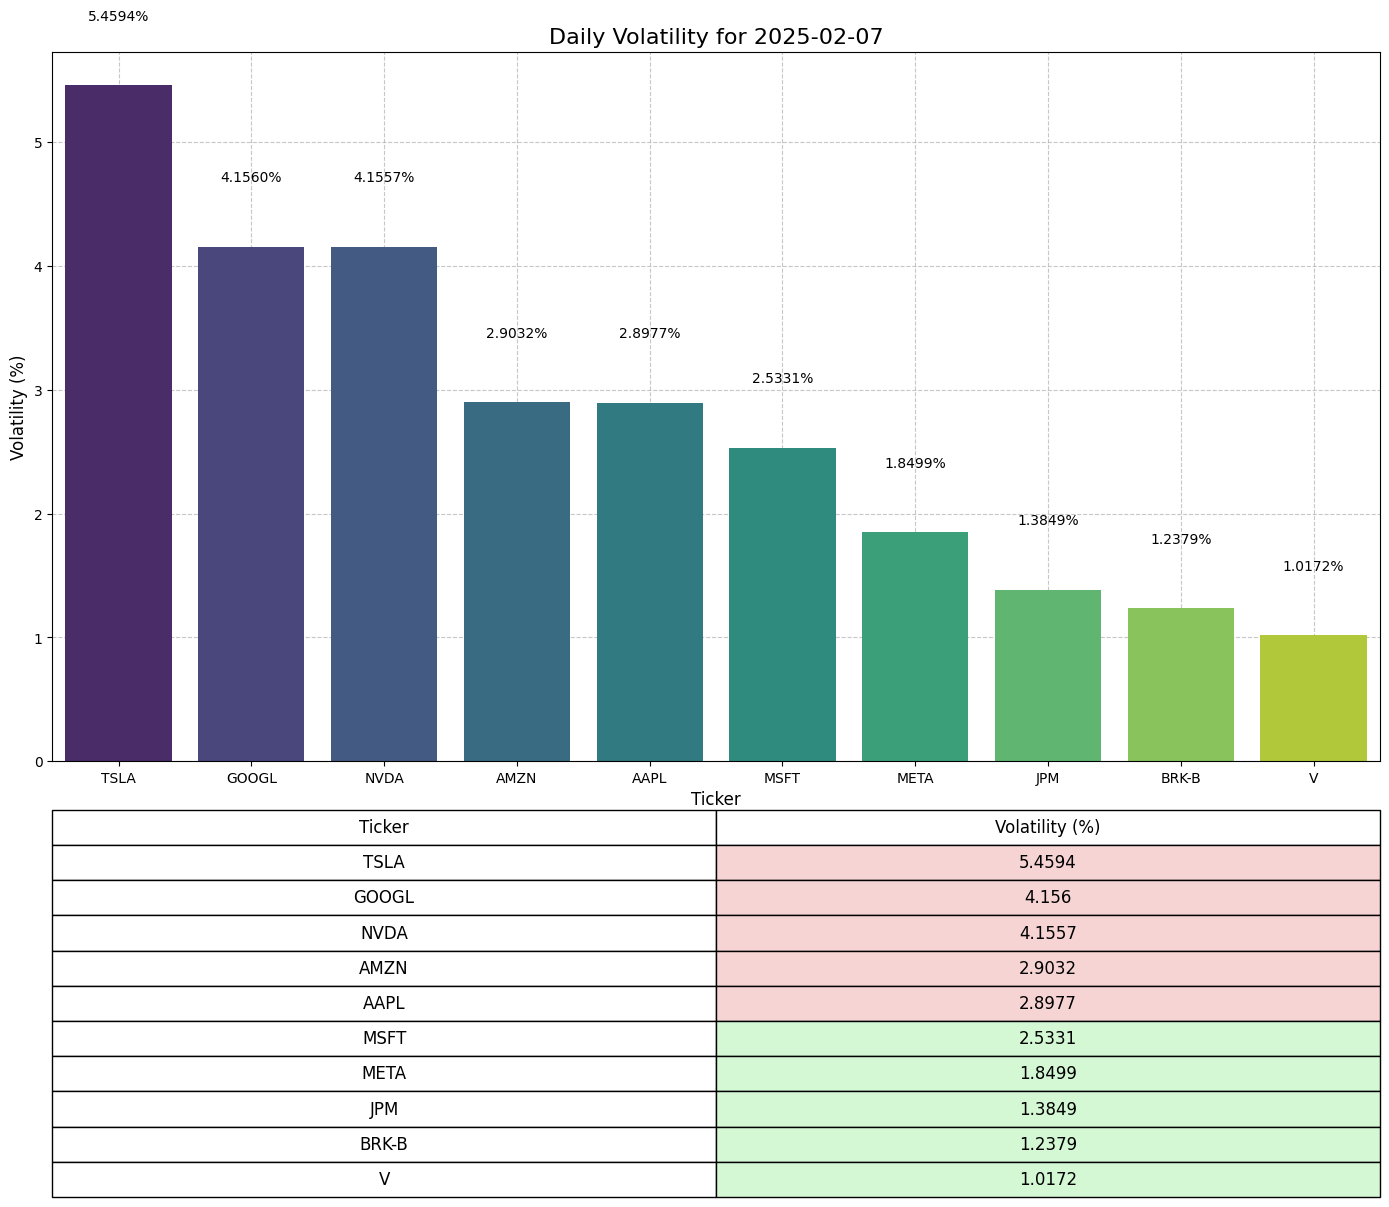

In [1]:
import yfinance as yf
import pandas as pda
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

# Define tickers for the 10 biggest stocks (by market cap)
tickers = ['AAPL', 'MSFT', 'AMZN', 'GOOGL', 'META', 'TSLA', 'NVDA', 'BRK-B', 'JPM', 'V']

# Get today's date
today = datetime.date.today()

# Download data for the past 10 days to ensure capturing the last trading day (even if weekends/holidays occurred)
end_date = today.strftime("%Y-%m-%d")
start_date = (today - datetime.timedelta(days=10)).strftime("%Y-%m-%d")

# Download daily OHLC data from Yahoo Finance
data = yf.download(tickers, start=start_date, end=end_date, interval="1d")

# Compute daily volatility for each ticker using the formula: ((High - Low) / Open) * 100
# We use the last available trading day in the dataset
last_date = data.index[-1]

volatility = {}
for ticker in tickers:
    try:
        open_price = data['Open'][ticker].iloc[-1]
        high_price = data['High'][ticker].iloc[-1]
        low_price = data['Low'][ticker].iloc[-1]
        vol = ((high_price - low_price) / open_price) * 100
        volatility[ticker] = vol
    except Exception as e:
        print(f"Error processing {ticker}: {e}")

# Create a DataFrame from the volatility dictionary and sort by volatility (highest first)
report_df = pd.DataFrame({
    'Ticker': list(volatility.keys()),
    'Volatility (%)': list(volatility.values())
})
report_df['Volatility (%)'] = report_df['Volatility (%)'].round(4)
report_df = report_df.sort_values(by='Volatility (%)', ascending=False)

# Print a nicely formatted table to the console
print(f"Daily Volatility for {last_date.date()}:")
print(report_df.to_string(index=False, formatters={'Volatility (%)': '{:.4f}'.format}))

# Save the table as a CSV file
report_df.to_csv("VolatilityReport.csv", index=False)

# Create a figure with two subplots: the top for the bar chart, the bottom for the table
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 12), gridspec_kw={'height_ratios': [4, 1]})

# --- Bar Chart ---
sns.barplot(x='Ticker', y='Volatility (%)', data=report_df, palette="viridis", ax=ax1)
ax1.set_title(f"Daily Volatility for {last_date.date()}", fontsize=16)
ax1.set_xlabel("Ticker", fontsize=12)
ax1.set_ylabel("Volatility (%)", fontsize=12)
ax1.set_axisbelow(True)
ax1.grid(True, which='both', linestyle='--', alpha=0.7)

# Add data labels on top of each bar (4 decimal places)
for patch in ax1.patches:
    height = patch.get_height()
    ax1.text(
        patch.get_x() + patch.get_width() / 2,
        height + 0.5,  # slightly above the bar
        f'{height:.4f}%',
        ha='center', va='bottom', fontsize=10, color='black'
    )

# --- Table ---
ax2.axis('off')
table = ax2.table(cellText=report_df.values,
                  colLabels=report_df.columns,
                  cellLoc='center',
                  loc='center')
table.auto_set_font_size(False)
table.set_fontsize(12)
table.scale(1, 2)

# Optional: Color-code the "Volatility (%)" column relative to the median volatility.
# Lower volatility (less risk) is shaded green, higher volatility red.
median_vol = report_df['Volatility (%)'].median()
for key, cell in table.get_celld().items():
    # Only process non-header rows for the "Volatility (%)" column (column index 1)
    if key[0] > 0 and key[1] == 1:
        try:
            value = float(cell.get_text().get_text().replace('%', ''))
            if value <= median_vol:
                cell.set_facecolor('#d4f7d4')  # light green for lower volatility
            else:
                cell.set_facecolor('#f7d4d4')  # light red for higher volatility
        except Exception:
            pass

# Adjust spacing between subplots to avoid overlap and save the figure as a PDF file
plt.subplots_adjust(hspace=0.4)
plt.tight_layout()
plt.savefig("VolatilityReport.pdf", format="pdf")

# Optionally, display the plot (if running in an environment that supports GUI)
plt.show()
